In [ ]:
#Importing needed libraries 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 5
import seaborn as sns
sns.set()
import tempfile
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV

In [2]:
#setting the mlflow traking uri
import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")


In [3]:
#reading in the csv file containing needed data
df = pd.read_csv("C:/Users/Namshima/Documents/Projects/New folder/archive/trip.csv")


In [ ]:
# Print first 5 rows 
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,1,7/1/2021 0:30,7/1/2021 0:35,N,1,74,168,1,1.20,6.0,0.5,0.5,0.00,0.0,NaN,0.3,7.30,2,1,0.0
1,2,7/1/2021 0:25,7/1/2021 1:01,N,1,116,265,2,13.69,42.0,0.5,0.5,0.00,0.0,NaN,0.3,43.30,2,1,0.0
2,2,7/1/2021 0:05,7/1/2021 0:12,N,1,97,33,1,0.95,6.5,0.5,0.5,2.34,0.0,NaN,0.3,10.14,1,1,0.0
3,2,7/1/2021 0:41,7/1/2021 0:47,N,1,74,42,1,1.24,6.5,0.5,0.5,0.00,0.0,NaN,0.3,7.80,2,1,0.0
4,2,7/1/2021 0:51,7/1/2021 0:58,N,1,42,244,1,1.10,7.0,0.5,0.5,0.00,0.0,NaN,0.3,8.30,2,1,0.0


In [ ]:
# Display dataset in
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13112 entries, 0 to 13111
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               13112 non-null  int64  
 1   lpep_pickup_datetime   13112 non-null  object 
 2   lpep_dropoff_datetime  13112 non-null  object 
 3   store_and_fwd_flag     13112 non-null  object 
 4   RatecodeID             13112 non-null  int64  
 5   PULocationID           13112 non-null  int64  
 6   DOLocationID           13112 non-null  int64  
 7   passenger_count        13112 non-null  int64  
 8   trip_distance          13112 non-null  float64
 9   fare_amount            13112 non-null  float64
 10  extra                  13112 non-null  float64
 11  mta_tax                13112 non-null  float64
 12  tip_amount             13112 non-null  float64
 13  tolls_amount           13112 non-null  float64
 14  ehail_fee              0 non-null      float64
 15  im

In [ ]:
#drop ehail_fee column as it contains 100% null values 
df.drop('ehail_fee', axis = 1, inplace = True)

In [ ]:
# Confirms proportion of missingness per column
df.isna().mean()

VendorID                 0.0
lpep_pickup_datetime     0.0
lpep_dropoff_datetime    0.0
store_and_fwd_flag       0.0
RatecodeID               0.0
PULocationID             0.0
DOLocationID             0.0
passenger_count          0.0
trip_distance            0.0
fare_amount              0.0
extra                    0.0
mta_tax                  0.0
tip_amount               0.0
tolls_amount             0.0
improvement_surcharge    0.0
total_amount             0.0
payment_type             0.0
trip_type                0.0
congestion_surcharge     0.0
dtype: float64

In [ ]:
# converts the date columns to pd datetime dtype
date = ['lpep_dropoff_datetime', 'lpep_pickup_datetime']
for col in date:
    df[col] = pd.to_datetime(df[col])

In [ ]:
# converts the cat_col columns to catergory datatype
cat_col = ['store_and_fwd_flag', 'RatecodeID', 'payment_type', 'trip_type', 'PULocationID', 'DOLocationID'] 
for col in cat_col:
    df[col] = df[col].astype('category')


In [10]:
# Feature extraction for pickup_datetime
df['pickup_year'] = df['lpep_pickup_datetime'].dt.year
df['pickup_month'] = df['lpep_pickup_datetime'].dt.month
df['pickup_dayofweek'] = df['lpep_pickup_datetime'].dt.dayofweek
df['pickup_day'] = df['lpep_pickup_datetime'].dt.day
df['pickup_hour'] = df['lpep_pickup_datetime'].dt.hour
df['pickup_minute'] = df['lpep_pickup_datetime'].dt.minute
df['pickup_second'] = df['lpep_pickup_datetime'].dt.second

In [11]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,payment_type,trip_type,congestion_surcharge,pickup_year,pickup_month,pickup_dayofweek,pickup_day,pickup_hour,pickup_minute,pickup_second
0,1,2021-07-01 00:30:00,2021-07-01 00:35:00,N,1,74,168,1,1.20,6.0,...,2,1,0.0,2021,7,3,1,0,30,0
1,2,2021-07-01 00:25:00,2021-07-01 01:01:00,N,1,116,265,2,13.69,42.0,...,2,1,0.0,2021,7,3,1,0,25,0
2,2,2021-07-01 00:05:00,2021-07-01 00:12:00,N,1,97,33,1,0.95,6.5,...,1,1,0.0,2021,7,3,1,0,5,0
3,2,2021-07-01 00:41:00,2021-07-01 00:47:00,N,1,74,42,1,1.24,6.5,...,2,1,0.0,2021,7,3,1,0,41,0
4,2,2021-07-01 00:51:00,2021-07-01 00:58:00,N,1,42,244,1,1.10,7.0,...,2,1,0.0,2021,7,3,1,0,51,0


In [ ]:
'''
creates the target column trip_duration which is the subtraction of the 
lpep_dropoff_datetime and lpep_pickup_datetime which returns seconds 
which are converted to minutes by division of 60
'''

df['trip_duration'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60

In [ ]:
# descriptive statistics in transpose 
df.describe().T

,count,mean,min,25%,50%,75%,max,std
VendorID,13112.0,1.835265,1.0,2.0,2.0,2.0,2.0,0.370955
lpep_pickup_datetime,13112,2021-07-03 23:39:21.232458752,2009-01-01 00:17:00,2021-07-02 17:21:45,2021-07-05 07:05:00,2021-07-07 08:31:15,2021-07-08 22:56:00,NaN
lpep_dropoff_datetime,13112,2021-07-04 00:03:20.417937920,2009-01-01 01:07:00,2021-07-02 17:44:45,2021-07-05 07:42:30,2021-07-07 08:51:00,2021-07-09 16:34:00,NaN
passenger_count,13112.0,1.276236,0.0,1.0,1.0,1.0,6.0,0.939212
trip_distance,13112.0,3.467294,0.0,1.04,1.91,3.8,37.98,4.601392
fare_amount,13112.0,15.12948,-50.0,7.0,10.5,17.0,156.0,14.614807
extra,13112.0,0.349832,-1.0,0.0,0.0,0.5,4.5,0.63683
mta_tax,13112.0,0.476586,-0.5,0.5,0.5,0.5,0.5,0.112627
tip_amount,13112.0,1.296955,-1.14,0.0,0.0,2.06,47.88,2.425337
tolls_amount,13112.0,0.357222,0.0,0.0,0.0,0.0,18.3,1.518222


In [ ]:
# dropping rows with cancelled trips

cancelled_trips = df[df['trip_duration'] == 0]
cancelled_trips
df.drop(cancelled_trips.index, axis = 0, inplace = True)

In [15]:
df['lpep_pickup_datetime'].dt.year.value_counts()

lpep_pickup_datetime
2021    12755
2009        3
Name: count, dtype: int64

In [ ]:
#dropping rows with corrupt data
corrupt_time = df[df['lpep_pickup_datetime'].dt.year == 2009]
df.drop(corrupt_time.index, axis = 0, inplace = True)

In [ ]:
# returns only rows where funds columns are greater than 0
funds = ['congestion_surcharge', 'total_amount', 'improvement_surcharge', 'tolls_amount', 'tip_amount', 'mta_tax', 'extra', 'fare_amount']
for col in funds:
    df = df[df[col] >= 0]

In [19]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
VendorID,12725.0,1.83332,1.0,2.0,2.0,2.0,2.0,0.372704
lpep_pickup_datetime,12725,2021-07-05 00:55:10.066797312,2021-06-07 15:15:00,2021-07-02 17:26:00,2021-07-05 08:18:00,2021-07-07 08:40:00,2021-07-08 22:56:00,NaN
lpep_dropoff_datetime,12725,2021-07-05 01:19:50.409430272,2021-06-07 16:45:00,2021-07-02 17:48:00,2021-07-05 08:41:00,2021-07-07 09:00:00,2021-07-09 16:34:00,NaN
passenger_count,12725.0,1.279214,0.0,1.0,1.0,1.0,6.0,0.945919
trip_distance,12725.0,3.56773,0.0,1.1,1.98,3.9,37.98,4.626809
fare_amount,12725.0,15.289432,0.0,7.0,10.5,17.0,156.0,14.574737
extra,12725.0,0.358585,0.0,0.0,0.0,0.5,4.5,0.642598
mta_tax,12725.0,0.486326,0.0,0.5,0.5,0.5,0.5,0.08155
tip_amount,12725.0,1.305523,0.0,0.0,0.0,2.06,47.88,2.404899
tolls_amount,12725.0,0.367572,0.0,0.0,0.0,0.0,18.3,1.538867


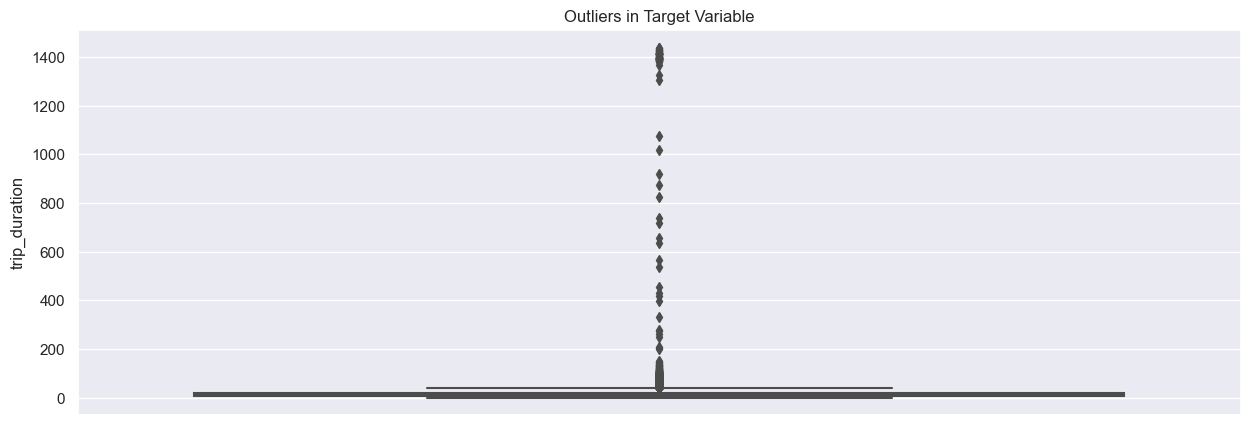

In [ ]:
# visualizing outliers
sns.boxplot(y='trip_duration',data = df)
plt.title("Outliers in Target Variable")
plt.show()

In [ ]:
'''I am not using the standard upper_limit = Q3 + 1.5 * IQR methood for the 
upper limit cause it is too small bassed on my analysis of the data I shall define one'''


Q1 = df['trip_duration'].quantile(0.25)
Q3 = df['trip_duration'].quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR

outlier_mask = (df['trip_duration'] < (Q1 - 1.5 * IQR)) | (df['trip_duration'] > (Q3 + 1.5 * IQR))
outliers = df['trip_duration'][outlier_mask]
print(f"Number of outliers: {outliers.shape[0]}")


Number of outliers: 1078


c:\Users\Namshima\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


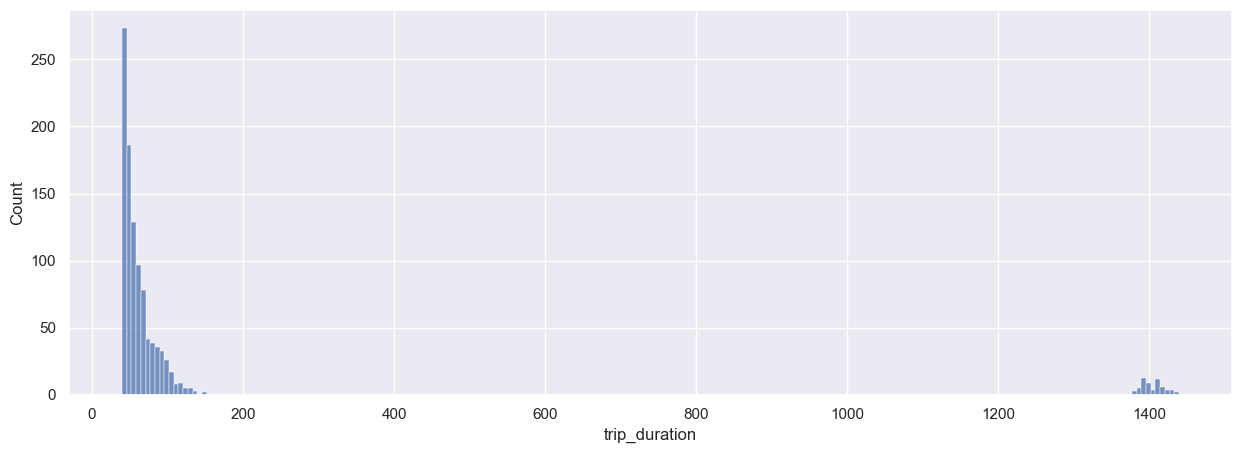

In [ ]:
#visualizing outliers
outliers = df[df['trip_duration'] > (Q3 + 1.5 * IQR)]

sns.histplot(outliers['trip_duration'])
plt.show()

In [23]:
outliers.describe()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,...,total_amount,congestion_surcharge,pickup_year,pickup_month,pickup_dayofweek,pickup_day,pickup_hour,pickup_minute,pickup_second,trip_duration
count,1078.000000,1078,1078,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,...,1078.000000,1078.000000,1078.0,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.0,1078.000000
mean,1.857143,2021-07-04 22:34:52.319109376,2021-07-05 01:06:39.851576832,1.226345,12.908080,49.271707,0.303803,0.484230,1.138080,2.577570,...,54.323163,0.275510,2021.0,6.993506,2.912801,4.549165,13.599258,28.638219,0.0,151.792208
min,1.000000,2021-06-07 15:15:00,2021-06-07 16:45:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2021.0,6.000000,0.000000,1.000000,0.000000,0.000000,0.0,40.000000
25%,2.000000,2021-07-02 14:39:45,2021-07-02 16:28:00,1.000000,6.452500,34.000000,0.000000,0.500000,0.000000,0.000000,...,37.300000,0.000000,2021.0,7.000000,2.000000,2.000000,11.000000,13.000000,0.0,46.000000
50%,2.000000,2021-07-05 10:27:00,2021-07-05 13:19:30,1.000000,12.535000,48.000000,0.000000,0.500000,0.000000,0.000000,...,52.300000,0.000000,2021.0,7.000000,3.000000,5.000000,14.000000,29.000000,0.0,56.000000
75%,2.000000,2021-07-07 10:22:30,2021-07-07 12:01:15,1.000000,19.157500,62.500000,0.500000,0.500000,0.000000,6.550000,...,70.300000,0.000000,2021.0,7.000000,4.000000,7.000000,17.000000,44.000000,0.0,78.000000
max,2.000000,2021-07-08 21:42:00,2021-07-09 16:34:00,6.000000,37.600000,156.000000,4.500000,0.500000,45.090000,18.300000,...,195.390000,2.750000,2021.0,7.000000,6.000000,11.000000,23.000000,59.000000,0.0,1439.000000
std,0.350090,NaN,NaN,0.695370,8.615547,21.999853,0.616155,0.087426,4.089517,3.379062,...,24.454255,0.826063,0.0,0.080358,1.648218,2.526534,4.360590,17.678993,0.0,327.070000


In [66]:
outliers_above_75_percentile.describe()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,...,total_amount,congestion_surcharge,pickup_year,pickup_month,pickup_dayofweek,pickup_day,pickup_hour,pickup_minute,pickup_second,trip_duration
count,269.000000,269,269,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,...,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.0,269.000000
mean,1.959108,2021-06-17 17:00:06.468401408,2021-06-18 00:30:38.364312320,1.141264,14.377807,56.492937,0.292751,0.477695,1.326357,2.506394,...,61.654126,0.276022,2020.955390,6.959108,2.977695,4.657993,13.301115,29.327138,0.0,450.531599
min,1.000000,2009-01-01 00:17:00,2009-01-01 06:01:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2009.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.0,79.000000
25%,2.000000,2021-07-02 14:04:00,2021-07-02 16:47:00,1.000000,6.280000,22.500000,0.000000,0.500000,0.000000,0.000000,...,29.960000,0.000000,2021.000000,7.000000,2.000000,2.000000,10.000000,15.000000,0.0,89.000000
50%,2.000000,2021-07-05 05:25:00,2021-07-05 14:42:00,1.000000,14.390000,63.000000,0.000000,0.500000,0.000000,0.000000,...,68.300000,0.000000,2021.000000,7.000000,3.000000,5.000000,14.000000,30.000000,0.0,104.000000
75%,2.000000,2021-07-07 14:55:00,2021-07-07 18:55:00,1.000000,22.820000,82.500000,0.500000,0.500000,0.000000,6.550000,...,89.350000,0.000000,2021.000000,7.000000,4.000000,7.000000,16.000000,46.000000,0.0,921.000000
max,2.000000,2021-07-08 20:22:00,2021-07-09 16:34:00,6.000000,37.600000,156.000000,4.500000,0.500000,38.800000,13.100000,...,156.800000,2.750000,2021.000000,7.000000,6.000000,10.000000,23.000000,59.000000,0.0,1439.000000
std,0.198410,NaN,NaN,0.451498,9.515157,32.242572,0.561542,0.103415,4.896616,3.265153,...,34.585729,0.827902,0.731653,0.388982,1.573885,2.631990,4.370273,17.509828,0.0,557.266473


In [39]:
df[df['trip_distance'] >= 10]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,trip_type,congestion_surcharge,pickup_year,pickup_month,pickup_dayofweek,pickup_day,pickup_hour,pickup_minute,pickup_second,trip_duration
1,2,2021-07-01 00:25:00,2021-07-01 01:01:00,N,1,116,265,2,13.69,42.0,...,1,0.00,2021,7,3,1,0,25,0,36.0
13,2,2021-07-01 00:31:00,2021-07-01 01:06:00,N,1,7,23,1,25.08,65.5,...,1,0.00,2021,7,3,1,0,31,0,35.0
16,2,2021-07-01 00:12:00,2021-07-01 01:05:00,N,1,226,75,1,11.40,42.0,...,1,0.00,2021,7,3,1,0,12,0,53.0
30,2,2021-07-01 01:14:00,2021-07-01 01:31:00,N,1,130,179,1,10.13,29.0,...,1,0.00,2021,7,3,1,1,14,0,17.0
45,2,2021-07-01 04:37:00,2021-07-01 05:24:00,N,1,126,235,1,13.16,45.5,...,1,0.00,2021,7,3,1,4,37,0,47.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13093,2,2021-07-08 21:42:00,2021-07-08 22:52:00,N,1,95,260,1,10.62,46.0,...,1,0.00,2021,7,3,8,21,42,0,70.0
13101,2,2021-07-08 21:57:00,2021-07-08 22:35:00,N,1,182,132,1,18.02,53.0,...,1,0.00,2021,7,3,8,21,57,0,38.0
13103,2,2021-07-08 21:04:00,2021-07-08 21:55:00,N,1,35,115,4,19.61,57.0,...,1,0.00,2021,7,3,8,21,4,0,51.0
13108,2,2021-07-08 22:27:00,2021-07-08 23:04:00,N,1,75,181,1,12.23,38.0,...,1,2.75,2021,7,3,8,22,27,0,37.0


In [ ]:
# sets the upper limit and returns a cliped version of the dataset
upper_limit = outliers['trip_duration'].quantile(0.75)
df['trip_duration'] = np.clip(df['trip_duration'], lower_limit, upper_limit)

In [44]:
df.describe()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,...,total_amount,congestion_surcharge,pickup_year,pickup_month,pickup_dayofweek,pickup_day,pickup_hour,pickup_minute,pickup_second,trip_duration
count,12725.000000,12725,12725,12725.000000,12725.000000,12725.000000,12725.000000,12725.000000,12725.000000,12725.000000,...,12725.000000,12725.000000,12725.0,12725.000000,12725.000000,12725.000000,12725.000000,12725.000000,12725.0,12725.000000
mean,1.833320,2021-07-05 00:55:10.066797312,2021-07-05 01:19:50.409430272,1.279214,3.567730,15.289432,0.358585,0.486326,1.305523,0.367572,...,18.644067,0.631473,2021.0,6.999136,2.904754,4.475521,13.634578,29.687230,0.0,16.818153
min,1.000000,2021-06-07 15:15:00,2021-06-07 16:45:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2021.0,6.000000,0.000000,1.000000,0.000000,0.000000,0.0,1.000000
25%,2.000000,2021-07-02 17:26:00,2021-07-02 17:48:00,1.000000,1.100000,7.000000,0.000000,0.500000,0.000000,0.000000,...,9.120000,0.000000,2021.0,7.000000,2.000000,2.000000,10.000000,15.000000,0.0,7.000000
50%,2.000000,2021-07-05 08:18:00,2021-07-05 08:41:00,1.000000,1.980000,10.500000,0.000000,0.500000,0.000000,0.000000,...,13.560000,0.000000,2021.0,7.000000,3.000000,5.000000,14.000000,30.000000,0.0,12.000000
75%,2.000000,2021-07-07 08:40:00,2021-07-07 09:00:00,1.000000,3.900000,17.000000,0.500000,0.500000,2.060000,0.000000,...,21.300000,0.000000,2021.0,7.000000,4.000000,7.000000,17.000000,44.000000,0.0,20.000000
max,2.000000,2021-07-08 22:56:00,2021-07-09 16:34:00,6.000000,37.980000,156.000000,4.500000,0.500000,47.880000,18.300000,...,207.480000,2.750000,2021.0,7.000000,6.000000,11.000000,23.000000,59.000000,0.0,78.000000
std,0.372704,NaN,NaN,0.945919,4.626809,14.574737,0.642598,0.081550,2.404899,1.538867,...,16.150540,1.156676,0.0,0.029390,1.721322,2.402804,5.020899,17.252209,0.0,15.586756


In [45]:
non_x = ['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'trip_duration']

In [46]:
numerical = ['RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'payment_type', 'trip_type', 'congestion_surcharge', 'pickup_year',
       'pickup_month', 'pickup_dayofweek', 'pickup_day', 'pickup_hour',
       'pickup_minute', 'pickup_second']

categorical = ['store_and_fwd_flag']

In [ ]:
# preprocessor pipline 
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), numerical),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical)
    ]
)

In [ ]:
x = df.drop(non_x, axis = 1) 
y = df['trip_duration'].values

In [49]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

In [50]:
x_train_processed = preprocessor.fit_transform(x_train).astype('float32')
x_test_processed = preprocessor.transform(x_test).astype('float32')

In [51]:
type(x_test_processed)

numpy.ndarray

In [ ]:
#Recursive feature elimination
rfe_rf = RFE(
    estimator = RandomForestRegressor()
    )

In [ ]:
#Recursive feature elimination using Randomforest regressor 
rfe_rf.fit(x_train_processed, y_train)

,estimator,RandomForestRegressor()
,n_features_to_select,None
,step,1
,verbose,0
,importance_getter,'auto'
,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


In [ ]:
# display column importance 
rfe_rf_rank = dict(zip(x_train.columns, rfe_rf.ranking_))
rfe_rf_rank

{'store_and_fwd_flag': 1,
 'RatecodeID': 1,
 'PULocationID': 1,
 'DOLocationID': 2,
 'passenger_count': 1,
 'trip_distance': 1,
 'fare_amount': 5,
 'extra': 4,
 'mta_tax': 1,
 'tip_amount': 8,
 'tolls_amount': 9,
 'improvement_surcharge': 1,
 'total_amount': 7,
 'payment_type': 3,
 'trip_type': 6,
 'congestion_surcharge': 12,
 'pickup_year': 11,
 'pickup_month': 1,
 'pickup_dayofweek': 1,
 'pickup_day': 1,
 'pickup_hour': 1,
 'pickup_minute': 13,
 'pickup_second': 10}

In [ ]:
#Recursive feature elimination for Decisiontreeregressor
rfe_tree = RFE(estimator = DecisionTreeRegressor())

In [ ]:
#fit and train
rfe_tree.fit(x_train_processed, y_train)

,estimator,DecisionTreeRegressor()
,n_features_to_select,None
,step,1
,verbose,0
,importance_getter,'auto'
,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


In [ ]:
# display column importance 
rfe_rf_tree = dict(zip(x_train.columns, rfe_tree.ranking_))
rfe_rf_tree

{'store_and_fwd_flag': 1,
 'RatecodeID': 1,
 'PULocationID': 1,
 'DOLocationID': 2,
 'passenger_count': 1,
 'trip_distance': 1,
 'fare_amount': 1,
 'extra': 5,
 'mta_tax': 3,
 'tip_amount': 8,
 'tolls_amount': 12,
 'improvement_surcharge': 1,
 'total_amount': 6,
 'payment_type': 7,
 'trip_type': 4,
 'congestion_surcharge': 10,
 'pickup_year': 13,
 'pickup_month': 1,
 'pickup_dayofweek': 1,
 'pickup_day': 1,
 'pickup_hour': 1,
 'pickup_minute': 11,
 'pickup_second': 9}

In [ ]:
#Recursive feature elimination for graientboostingregressor
rfe_gb = RFE(estimator = GradientBoostingRegressor())

In [ ]:
# fit and train 
rfe_gb.fit(x_train_processed, y_train)

,estimator,GradientBoostingRegressor()
,n_features_to_select,None
,step,1
,verbose,0
,importance_getter,'auto'
,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2


In [ ]:
# display column importance 
rfe_gb_rank = dict(zip(x_train.columns, rfe_gb.ranking_))
rfe_gb_rank

{'store_and_fwd_flag': 1,
 'RatecodeID': 1,
 'PULocationID': 1,
 'DOLocationID': 8,
 'passenger_count': 1,
 'trip_distance': 1,
 'fare_amount': 5,
 'extra': 4,
 'mta_tax': 1,
 'tip_amount': 2,
 'tolls_amount': 11,
 'improvement_surcharge': 1,
 'total_amount': 7,
 'payment_type': 1,
 'trip_type': 6,
 'congestion_surcharge': 9,
 'pickup_year': 10,
 'pickup_month': 1,
 'pickup_dayofweek': 1,
 'pickup_day': 1,
 'pickup_hour': 3,
 'pickup_minute': 12,
 'pickup_second': 13}

In [ ]:
# fit and train on lassocv for feature importance
lcv = LassoCV()
lcv.fit(x_train_processed, y_train)

,eps,0.001
,n_alphas,'deprecated'
,alphas,'warn'
,fit_intercept,True
,precompute,'auto'
,max_iter,1000
,tol,0.0001
,copy_X,True
,cv,None
,verbose,False
,n_jobs,None


In [ ]:
# return feature importance

lcv_mask = lcv.coef_ != 0
rf_mask = rfe_rf.support_
gb_mask = rfe_gb.support_
tree_mask = rfe_tree.support_

In [ ]:
# collect votes for feature importance 
votes = np.sum([lcv_mask, rf_mask, gb_mask, tree_mask], axis = 0)
final_mask = votes >= 3
reduced_x = x.loc[:, final_mask]


In [66]:
selected_columns = [
    'RatecodeID', 'PULocationID', 'passenger_count', 'trip_distance', 'mta_tax', 
    'improvement_surcharge', 'pickup_month', 'pickup_dayofweek','pickup_day', 'pickup_hour'
    ]

all_feature_names = ['store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'payment_type', 'trip_type', 'congestion_surcharge', 'pickup_year',
       'pickup_month', 'pickup_dayofweek', 'pickup_day', 'pickup_hour',
       'pickup_minute', 'pickup_second']

In [67]:
selected_indices = [all_feature_names.index(col) for col in selected_columns]

In [68]:
x_train_selected = x_train_processed[:, selected_indices]
x_test_selected = x_test_processed[:, selected_indices]


In [69]:
estimators = {
    #"Decision Tree Classifier": DecisionTreeRegressor(),
    "Random Forest ": RandomForestRegressor(),
    "Gradient Boosting ": GradientBoostingRegressor(),
    "Ada Boosting ": AdaBoostRegressor(),
    "Bagging ": BaggingRegressor(),
    "Xgb ": XGBRegressor()
}

In [ ]:
mlflow.sklearn.autolog()
mlflow.xgboost.autolog()

for model_name, model in estimators.items():
    with mlflow.start_run(run_name=f"Base Model - {model_name}"):
        # Train and evaluate base model
        model.fit(x_train_processed, y_train)
        
        # Predictions
        base_train_pred = model.predict(x_train_processed)
        base_test_pred = model.predict(x_test_processed)

        # Metrics

        #R2score
        base_train_r2 = r2_score(y_train, base_train_pred)
        base_test_r2 = r2_score(y_test, base_test_pred)
        
        #Mean absolute error
        base_train_mae = mean_absolute_error(y_train, base_train_pred)
        base_test_mae = mean_absolute_error(y_test, base_test_pred)
        
        #Mean squared error
        base_train_mse = mean_squared_error(y_train, base_train_pred)
        base_test_mse = mean_squared_error(y_test, base_test_pred)
        
               
        # Display base model scores 
        print(f"\n=== {model_name} ===")
        print(f"Train R²: {base_train_r2:.3f} | Test R²: {base_test_r2:.3f}")
        print(f"Train MAE: {base_train_mae:.3f} | Test MAE: {base_test_mae:.3f}")
        print(f"Train MSE: {base_train_mse:.3f} | Test MSE: {base_test_mse:.3f}")



=== Random Forest  ===
Train R²: 0.975 | Test R²: 0.858
Train MAE: 0.935 | Test MAE: 2.274
Train MSE: 6.044 | Test MSE: 33.931
🏃 View run Base Model - Random Forest  at: http://127.0.0.1:5000/#/experiments/0/runs/48edede4da46478e8d70f014aee1c413
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0

=== Gradient Boosting  ===
Train R²: 0.843 | Test R²: 0.849
Train MAE: 2.641 | Test MAE: 2.623
Train MSE: 38.338 | Test MSE: 36.012
🏃 View run Base Model - Gradient Boosting  at: http://127.0.0.1:5000/#/experiments/0/runs/a57e01f1e54b4286840834e48e1d5d02
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0

=== Ada Boosting  ===
Train R²: 0.676 | Test R²: 0.690
Train MAE: 6.134 | Test MAE: 6.051
Train MSE: 79.228 | Test MSE: 73.824
🏃 View run Base Model - Ada Boosting  at: http://127.0.0.1:5000/#/experiments/0/runs/3468d4d2ff7c4786bef907cd83a8f1e4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0

=== Bagging  ===
Train R²: 0.964 | Test R²: 0.840
Train MAE: 1.068 | T

In [71]:
model_params = {
    "RandomForestRegressor": {
        "Model": RandomForestRegressor(random_state = 0), 
        "params": {
            'n_estimators': [50, 100, 150], 
            #'criterion': ['squared_error', 'absolute_error','friedman_mse', 'poisson'],
            'max_depth': [None, 30, 50], 
            'min_samples_leaf': [2, 5, 10],
            'max_features': ['sqrt', 'log2', None],
            'min_samples_split': [2, 5, 10]
        }
    },
    "GradientBoostingRegressor": {
        'Model': GradientBoostingRegressor(random_state = 0),
        'params':{
            'learning_rate': [0.1, 0.3, 0.5],
            'n_estimators': [50, 100, 150], 
            'min_samples_split': [2, 5, 10],
            'min_samples_split': [2, 5, 10],
            'max_depth': [None, 30, 50],
            'max_features': ['sqrt', 'log2', None]
        }
    }, 
    "XGBRegressor":{
        'Model': XGBRegressor(random_state = 0),
        'params':{
            'max_depth': [None, 3, 5, 10],
            'n_estimators': [100, 120, 150],
            'subsample': [0.7, 0.8, 0.9, 1.0]
        }
    }
}

In [ ]:
for name, mp in model_params.items():
    with mlflow.start_run(run_name=f"Coarse Random Tuning({name})"):
        print(f"\n🔍 Running RandomizedSearchCV for: {name}")
    
        model = mp["Model"]
        param_dist = mp["params"]
    
        search = RandomizedSearchCV(
            estimator = model,
            param_distributions = param_dist,
            n_iter = 100,
            cv = 3,
            scoring='neg_mean_squared_error',
            n_jobs = -1,
            random_state = 0,
            verbose = 0
        )
    
        search.fit(x_train_processed, y_train)

        print(f"✅ Best score for {name}: {search.best_score_:.4f}")
        print(f"🧠 Best params: {search.best_params_}")
        
        #save the best estimator
        best_estimator = search.best_estimator_

         # Predictions
        coarse_tuning_train_pred = best_estimator.predict(x_train_processed)
        coarse_tuning_test_pred = best_estimator.predict(x_test_processed)

        # Metrics

        #R2score
        coarse_tuning_train_r2 = r2_score(y_train, coarse_tuning_train_pred)
        coarse_tuning_test_r2 = r2_score(y_test, coarse_tuning_test_pred)
        
        #Mean absolute error
        coarse_tuning_train_mae = mean_absolute_error(y_train, coarse_tuning_train_pred)
        coarse_tuning_test_mae = mean_absolute_error(y_test, coarse_tuning_test_pred)
        
        #Mean squared error
        coarse_tuning_train_mse = mean_squared_error(y_train, coarse_tuning_train_pred)
        coarse_tuning_test_mse = mean_squared_error(y_test, coarse_tuning_test_pred)
        
               
        # Display base model scores 
        print(f"\n=== {name} ===")
        print(f"Train R²: {coarse_tuning_train_r2:.3f} | Test R²: {coarse_tuning_test_r2:.3f}")
        print(f"Train MAE: {coarse_tuning_train_mae:.3f} | Test MAE: {coarse_tuning_test_mae:.3f}")
        print(f"Train MSE: {coarse_tuning_train_mse:.3f} | Test MSE: {coarse_tuning_test_mse:.3f}")




🔍 Running RandomizedSearchCV for: RandomForestRegressor


2025/10/16 18:00:39 INFO mlflow.sklearn.utils: Logging the 5 best runs, 95 runs will be omitted.


🏃 View run capricious-gnu-906 at: http://127.0.0.1:5000/#/experiments/0/runs/023c33089f744c88a59b8c11fa7264d0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run stately-wasp-570 at: http://127.0.0.1:5000/#/experiments/0/runs/f31b3f89768b4e64abb467015c81e427
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run bemused-shrike-898 at: http://127.0.0.1:5000/#/experiments/0/runs/9dee9f52d1864d49a4749bc906b49e3e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run stylish-grub-27 at: http://127.0.0.1:5000/#/experiments/0/runs/74c06dcb11144cb4929f62c9ee2d2920
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run brawny-goose-393 at: http://127.0.0.1:5000/#/experiments/0/runs/5500600a8cd4459f8f055649f218bd21
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
✅ Best score for RandomForestRegressor: -44.2915
🧠 Best params: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, '

2025/10/16 18:09:25 INFO mlflow.sklearn.utils: Logging the 5 best runs, 95 runs will be omitted.


🏃 View run enchanting-sloth-81 at: http://127.0.0.1:5000/#/experiments/0/runs/9297a46c7e4043d39ecac2a1b7d76adb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run masked-grub-949 at: http://127.0.0.1:5000/#/experiments/0/runs/647cdda83fc8485992627b1910dc2029
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run traveling-dog-277 at: http://127.0.0.1:5000/#/experiments/0/runs/db233161010f4de49542bb95f99ab36f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run intelligent-roo-569 at: http://127.0.0.1:5000/#/experiments/0/runs/6f19376cd79b4379a98083b4ea5b942c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run tasteful-doe-667 at: http://127.0.0.1:5000/#/experiments/0/runs/4a4ac77dcaf346f19012f8e59eda70af
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
✅ Best score for GradientBoostingRegressor: -47.8302
🧠 Best params: {'n_estimators': 50, 'min_samples_split': 10, 'max_features': 'log2', 'max_depth': Non

c:\Users\Namshima\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
2025/10/16 18:10:33 INFO mlflow.sklearn.utils: Logging the 5 best runs, 43 runs will be omitted.


🏃 View run welcoming-ox-499 at: http://127.0.0.1:5000/#/experiments/0/runs/3e745e91c00e4a5a83c575a149d413da
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run capricious-stag-130 at: http://127.0.0.1:5000/#/experiments/0/runs/0dcd3813bc4a447394702bbb862802a2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run bouncy-auk-677 at: http://127.0.0.1:5000/#/experiments/0/runs/a48eabf25e96486aabb85c7253cbe1f4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run shivering-carp-421 at: http://127.0.0.1:5000/#/experiments/0/runs/b1cebb9b2cd249e49468bdf032e19df7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run clumsy-doe-615 at: http://127.0.0.1:5000/#/experiments/0/runs/041d346cf5154514b6b8c865c15ba4c4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
✅ Best score for XGBRegressor: -42.9433
🧠 Best params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3}

=== Xgb  ===
Train R²: 0.874 | Test R²: 0.864
T

In [75]:
grid_params = {
    "RandomForestRegressor" : {
        'Model' : RandomForestRegressor(random_state = 0),
        'params':{
            'n_estimators': [130, 150, 200], 
            'max_depth': [50, 60], 
            'min_samples_leaf': [2, 3],
            'max_features': ['sqrt', 'log2', None],
            'min_samples_split': [10, 20]
        }
    },
    "GradientBoostingRegressor": {
        'Model': GradientBoostingRegressor(random_state = 0),
        'params':{
            'learning_rate': [0.1, 0.3],
            'n_estimators': [50, 70], 
            'min_samples_split': [5, 10, 15],
            'min_samples_split': [2, 5, 10],
            'max_depth': [None, 30],
            'max_features': ['sqrt', 'log2', None]
        }
    },  
    "XGBRegressor":{
        'Model': XGBRegressor(random_state = 0),
        'params':{
            'max_depth': [None, 3, 5, 10],
            'n_estimators': [50, 100],
            'subsample': [0.8, 0.9]
        }
    }

}

In [ ]:
for name, mp in grid_params.items():
    with mlflow.start_run(run_name=f"Coarse Grid Tuning({name})"):
        print(f"\n🔍 Running GridSearchCV for: {name}")
    
        model = mp["Model"]
        param_dist = mp["params"]
    
        search_grid = GridSearchCV(
            estimator = model,
            param_grid = param_dist,
            scoring = 'neg_mean_squared_error',
            n_jobs = -1,
            cv = 7
        )
    
        search_grid.fit(x_train_processed, y_train)

        print(f"✅ Best score for {name}: {search_grid.best_score_:.4f}")
        print(f"🧠 Best params: {search_grid.best_params_}")
        
        #save the best estimator
        grid_best_estimator = search_grid.best_estimator_

         # Predictions
        coarse_tuning_train_pred = grid_best_estimator.predict(x_train_processed)
        coarse_tuning_test_pred = grid_best_estimator.predict(x_test_processed)

        # Metrics

        #R2score
        coarse_tuning_train_r2 = r2_score(y_train, coarse_tuning_train_pred)
        coarse_tuning_test_r2 = r2_score(y_test, coarse_tuning_test_pred)
        
        #Mean absolute error
        coarse_tuning_train_mae = mean_absolute_error(y_train, coarse_tuning_train_pred)
        coarse_tuning_test_mae = mean_absolute_error(y_test, coarse_tuning_test_pred)
        
        #Mean squared error
        coarse_tuning_train_mse = mean_squared_error(y_train, coarse_tuning_train_pred)
        coarse_tuning_test_mse = mean_squared_error(y_test, coarse_tuning_test_pred)
        
               
        # Display base model scores 
        print(f"\n=== {name} ===")
        print(f"Train R²: {coarse_tuning_train_r2:.3f} | Test R²: {coarse_tuning_test_r2:.3f}")
        print(f"Train MAE: {coarse_tuning_train_mae:.3f} | Test MAE: {coarse_tuning_test_mae:.3f}")
        print(f"Train MSE: {coarse_tuning_train_mse:.3f} | Test MSE: {coarse_tuning_test_mse:.3f}")




🔍 Running GridSearchCV for: RandomForestRegressor


2025/10/16 20:26:56 INFO mlflow.sklearn.utils: Logging the 5 best runs, 67 runs will be omitted.


🏃 View run caring-toad-806 at: http://127.0.0.1:5000/#/experiments/0/runs/18fc3d63c0cb4c339b14062cc0c4dece
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run spiffy-hog-797 at: http://127.0.0.1:5000/#/experiments/0/runs/540d8d8f922d49f8a7bf00e276b42666
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run caring-wren-748 at: http://127.0.0.1:5000/#/experiments/0/runs/7f1e77646c0e48dcb02df13b947529a3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run puzzled-hound-693 at: http://127.0.0.1:5000/#/experiments/0/runs/8ef219f6ebd34bcfa2fd44965c484f26
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run ambitious-mink-56 at: http://127.0.0.1:5000/#/experiments/0/runs/e6ef05c183024c34bd9c198f9455affb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
✅ Best score for RandomForestRegressor: -41.8945
🧠 Best params: {'max_depth': 50, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimat

2025/10/16 20:40:18 INFO mlflow.sklearn.utils: Logging the 5 best runs, 67 runs will be omitted.


🏃 View run hilarious-wolf-128 at: http://127.0.0.1:5000/#/experiments/0/runs/ff16d05880104af0a2d5078951c37ff2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run flawless-kit-114 at: http://127.0.0.1:5000/#/experiments/0/runs/44030d49dfca49dc82c6b88b3e4c3f00
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run popular-shoat-848 at: http://127.0.0.1:5000/#/experiments/0/runs/0e122306167244b08b62a603d6248a4a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run caring-ram-406 at: http://127.0.0.1:5000/#/experiments/0/runs/8825f756268f4e05b10e3eb909337b5f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run bemused-bear-855 at: http://127.0.0.1:5000/#/experiments/0/runs/91e5ac78e012465f80d9332f219d7ae6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
✅ Best score for GradientBoostingRegressor: -46.1859
🧠 Best params: {'learning_rate': 0.1, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 10, 

2025/10/16 20:43:17 INFO mlflow.sklearn.utils: Logging the 5 best runs, 11 runs will be omitted.


🏃 View run unique-gnat-898 at: http://127.0.0.1:5000/#/experiments/0/runs/ef28a6de21a64f73bb4cc16add0b500d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run respected-rook-584 at: http://127.0.0.1:5000/#/experiments/0/runs/51d5525980e940cb815051abd56f7802
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run bold-bug-377 at: http://127.0.0.1:5000/#/experiments/0/runs/fb6d1d4aa1864ef6a526bc6a91e31f85
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run colorful-dolphin-589 at: http://127.0.0.1:5000/#/experiments/0/runs/d7887e9f7f0446708fa26cdeb4ac12d0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run mercurial-sheep-377 at: http://127.0.0.1:5000/#/experiments/0/runs/def11422d957402f83784970aded4b07
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
✅ Best score for XGBRegressor: -41.8205
🧠 Best params: {'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}

=== XGBRegressor ===
Train R²: 0.878 | Test 

In [ ]:
fine_params = {
    "RandomForestRegressor" : {
        'Model' : RandomForestRegressor(random_state = 0),
        'params':{
            'n_estimators': [200, 250, 300], 
            'max_depth': [50, 60], 
            'min_samples_leaf': [3, 4, 5],
            'max_features': [None],
            'min_samples_split': [10, 15, 20]
        }#{'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 50}
    },#{'max_depth': 50, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 200}

    "XGBRegressor":{
        'Model': XGBRegressor(random_state = 0),
        'params':{
            'max_depth': [3],
            'n_estimators': [100, 150, 200],
            'subsample': [0.9, 1.0], 
            'learning_rate' : [0.001, 0.01, 0.3]
        }
    }#{'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3}

#{'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}

}

In [81]:
for name, mp in fine_params.items():
    with mlflow.start_run(run_name=f"Fine Tuning({name})"):
        print(f"\n🔍 Running GridSearchCV for: {name}")
    
        model = mp["Model"]
        param_dist = mp["params"]
    
        fine_search = GridSearchCV(
            estimator = model,
            param_grid = param_dist,
            scoring = 'neg_mean_squared_error',
            n_jobs = -1,
            cv = 10
        )
    
        fine_search.fit(x_train_processed, y_train)

        print(f"✅ Best score for {name}: {fine_search.best_score_:.4f}")
        print(f"🧠 Best params: {fine_search.best_params_}")
        
        #save the best estimator
        fine_best_estimator = fine_search.best_estimator_

         # Predictions
        fine_tuning_train_pred = fine_best_estimator.predict(x_train_processed)
        fine_tuning_test_pred = fine_best_estimator.predict(x_test_processed)

        # Metrics

        #R2score
        fine_tuning_train_r2 = r2_score(y_train, fine_tuning_train_pred)
        fine_tuning_test_r2 = r2_score(y_test, fine_tuning_test_pred)
        
        #Mean absolute error
        fine_tuning_train_mae = mean_absolute_error(y_train, fine_tuning_train_pred)
        fine_tuning_test_mae = mean_absolute_error(y_test, fine_tuning_test_pred)
        
        #Mean squared error
        fine_tuning_train_mse = mean_squared_error(y_train, fine_tuning_train_pred)
        fine_tuning_test_mse = mean_squared_error(y_test, fine_tuning_test_pred)
        
               
        # Display base model scores 
        print(f"\n=== {name} ===")
        print(f"Train R²: {fine_tuning_train_r2:.3f} | Test R²: {fine_tuning_test_r2:.3f}")
        print(f"Train MAE: {fine_tuning_train_mae:.3f} | Test MAE: {fine_tuning_test_mae:.3f}")
        print(f"Train MSE: {fine_tuning_train_mse:.3f} | Test MSE: {fine_tuning_test_mse:.3f}")




🔍 Running GridSearchCV for: RandomForestRegressor


2025/10/16 22:41:16 INFO mlflow.sklearn.utils: Logging the 5 best runs, 49 runs will be omitted.


🏃 View run legendary-shad-505 at: http://127.0.0.1:5000/#/experiments/0/runs/e753a9d1cf754b408ceaa2074cd5e6d4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run rebellious-deer-558 at: http://127.0.0.1:5000/#/experiments/0/runs/ba26ac4077b14e65aa8474f5e399fcc8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run casual-quail-820 at: http://127.0.0.1:5000/#/experiments/0/runs/ea6b0ab288bd42bca8b22444d9d5aa05
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run treasured-horse-991 at: http://127.0.0.1:5000/#/experiments/0/runs/f13c28a59c32402eb7d177252432e3eb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run victorious-ox-703 at: http://127.0.0.1:5000/#/experiments/0/runs/fa8dfc4845ad439587d4ca0030a1d582
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
✅ Best score for RandomForestRegressor: -42.0593
🧠 Best params: {'max_depth': 50, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 10,

2025/10/16 22:42:48 INFO mlflow.sklearn.utils: Logging the 5 best runs, 13 runs will be omitted.


🏃 View run adaptable-mink-975 at: http://127.0.0.1:5000/#/experiments/0/runs/66474a92db06463ea7c1ec9dfe598bd3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run hilarious-elk-551 at: http://127.0.0.1:5000/#/experiments/0/runs/03bef58042e3483f9a95812662ab83c4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run bold-koi-895 at: http://127.0.0.1:5000/#/experiments/0/runs/c7f8197a31ee4143bde0547a5ed798cb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run dapper-skunk-297 at: http://127.0.0.1:5000/#/experiments/0/runs/d98712e04f25495eb78d8a416f5a0983
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run dazzling-dolphin-398 at: http://127.0.0.1:5000/#/experiments/0/runs/2fb444ea18a24342adab7ed88439f567
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
✅ Best score for XGBRegressor: -41.8391
🧠 Best params: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}

=== XGBRegressor ===
Tr

In [101]:
final_estimators = {'XGBRegressor' : XGBRegressor(
    learning_rate= 0.03, 
    max_depth= 3, 
    n_estimators= 160, 
    subsample= 0.5,
    random_state = 0
),#'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}

#"RandomForestRegressor": RandomForestRegressor(
#    max_depth =50, 
 #   max_features= None, 
#    min_samples_leaf= 3, 
#    min_samples_split =10, 
#    n_estimators =200
#)
}

In [102]:
for name, model in final_estimators.items():
    with mlflow.start_run(run_name = f"{name} final Model"):
        print(f"==== Training {name} ====")

        model = model
        
        #training
        model.fit(x_train_processed, y_train)
        
        #predicting on training data
        training_pred = model.predict(x_train_processed)

        #Training evaluation 
        traininig_r2_score = r2_score(y_train, training_pred)
        traininig_mean_absolute_error = mean_absolute_error(y_train, training_pred)
        traininig_mean_squared_error = mean_squared_error(y_train, training_pred)

        print(f"==== Evaluating {name} ====")

        #Predicting using test dataset
        y_pred = model.predict(x_test_processed)

        #Test Evaluation 

        test_r2_score = r2_score(y_test, y_pred)
        test_mean_absolute_error = mean_absolute_error(y_test, y_pred)
        test_mean_squared_error = mean_squared_error(y_test, y_pred)

        # Log metrics
        #mlflow.log_metric("train_r2", base_train_r2)
        mlflow.log_metric("Test_r2", test_r2_score)
        #mlflow.log_metric("train_mae", base_train_mae)
        mlflow.log_metric("Test_mae", test_mean_absolute_error)
        #mlflow.log_metric("train_mse", base_train_mse)
        mlflow.log_metric("Test_mse", test_mean_squared_error)  

        # Display base model scores 
        print(f"\n=== {name} ===")
        print(f"Train R²: {traininig_r2_score:.3f} | Test R²: {test_r2_score:.3f}")
        print(f"Train MAE: {traininig_mean_absolute_error:.3f} | Test MAE: {test_mean_absolute_error:.3f}")
        print(f"Train MSE: {traininig_mean_squared_error:.3f} | Test MSE: {test_mean_squared_error:.3f}")

 



==== Training XGBRegressor ====
==== Evaluating XGBRegressor ====

=== XGBRegressor ===
Train R²: 0.817 | Test R²: 0.833
Train MAE: 3.035 | Test MAE: 2.987
Train MSE: 44.883 | Test MSE: 39.744
🏃 View run XGBRegressor final Model at: http://127.0.0.1:5000/#/experiments/0/runs/9e4cc0633d9343d1a85ad21f1464d34e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


In [103]:
for name, model in final_estimators.items():
    print(f"==== Running Cross validation for {name} ====")
    mse_cv = cross_val_score(
        estimator = model,
        X = x_train_processed,
        y = y_train,
        scoring = 'neg_mean_squared_error',
        n_jobs = -1,
        cv = 10
    )

    mean_score = mse_cv.mean()
    print(f"{name} CV Mean Squared Error : {mean_score}")

==== Running Cross validation for XGBRegressor ====
XGBRegressor CV Mean Squared Error : -48.53274912404075


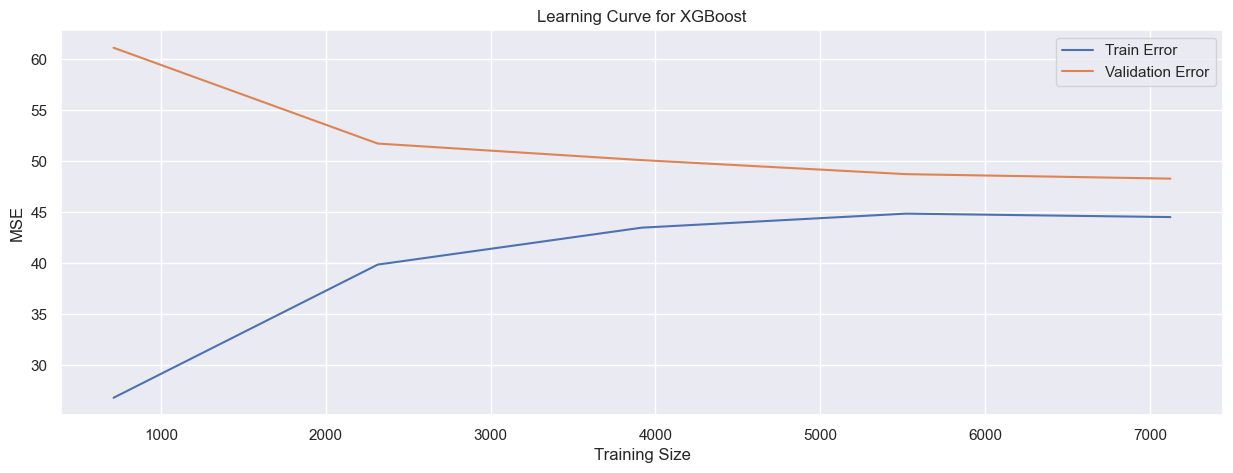

In [ ]:
best_xgb = XGBRegressor(
    learning_rate= 0.03, 
    max_depth= 3, 
    n_estimators= 160, 
    subsample= 0.5,
    random_state = 0
)


from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_xgb, x_train_processed, y_train, scoring='neg_mean_squared_error', cv=5
)

plt.plot(train_sizes, -train_scores.mean(axis=1), label="Train Error")
plt.plot(train_sizes, -val_scores.mean(axis=1), label="Validation Error")
plt.legend(); plt.xlabel("Training Size"); plt.ylabel("MSE")
plt.title("Learning Curve for XGBoost")
plt.show()


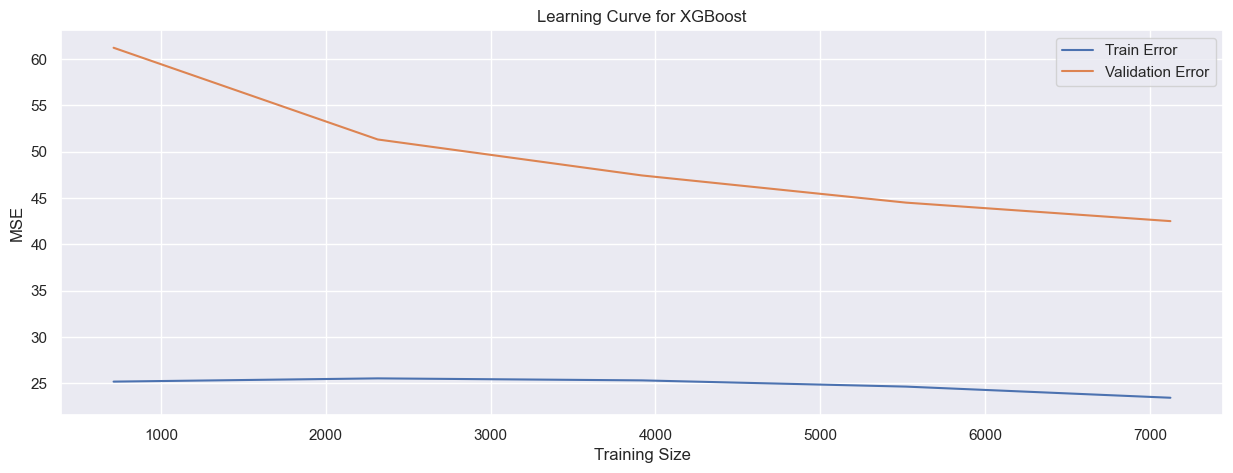

In [ ]:
best_rf = RandomForestRegressor(
    max_depth =50, 
    max_features= None, 
    min_samples_leaf= 3, 
    min_samples_split =10, 
    n_estimators =200
)

train_sizes, train_scores, val_scores = learning_curve(
    best_rf, x_train_processed, y_train, scoring='neg_mean_squared_error', cv=5
)

plt.plot(train_sizes, -train_scores.mean(axis=1), label="Train Error")
plt.plot(train_sizes, -val_scores.mean(axis=1), label="Validation Error")
plt.legend(); plt.xlabel("Training Size"); plt.ylabel("MSE")
plt.title("Learning Curve for Randomforest")
plt.show()
